In [1]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from preprocess import extract_images
from dataset import get_full_list, ChineseCharacterDataset
from models import VAE, vae_loss, ConvVAE
from utils import visualize_images, show_images

In [2]:
%load_ext autoreload
%autoreload 2

### Loading and Preprocessing:

In [3]:
# Set the directory and load the dataset
image_dir = './dataset'
full_data_list = get_full_list(image_dir)

train_size = int(0.01*len(full_data_list))
train_data_set = ChineseCharacterDataset(full_data_list[:train_size], cond_type='Half')

print("Training Set Size:", len(train_data_set))

# Create data loaders
train_loader = DataLoader(train_data_set, batch_size=32, shuffle=True)

Training Set Size: 2435


### Model:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(CVAE, self).__init__()
        self.z_dim = z_dim
        self.condition_dim = condition_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2*input_dim, hidden_dim),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(hidden_dim, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim, z_dim)
        
        # Condition encoder
        self.condition_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 8, condition_dim) 
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim + condition_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x, condition):
        # Pad condition to match the height of x
        condition_padded = F.pad(condition, (0, 0, 0, 32))  # Padding only height
        # Concatenate the condition with the input image
        x_cond = torch.cat([x, condition_padded], dim=1)
        h1 = self.encoder(x_cond)
        return self.fc_mu(h1), self.fc_logvar(h1)   

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, condition):
        # Encode the condition
        cond_encoded = self.condition_encoder(condition)
        # Concatenate z with the encoded condition
        z_cond = torch.cat([z, cond_encoded], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, condition):
        mu, logvar = self.encode(x, condition)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, condition), mu, logvar

### Training:

In [5]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
# Train
def train(model, train_data_set, input_dim, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, condition) in enumerate(train_data_set):
            data = data.to(device)
            condition = condition.to(device)
            optimizer.zero_grad()
            reconstructed_batch, mu, logvar = model(data, condition)
            loss = vae_loss(reconstructed_batch.view(data.shape[0],1,64,64), data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_data_set.dataset)}')
    print(f'Final Loss: {train_loss/len(train_data_set.dataset)}')

In [7]:
input_dim = 64 * 64
z_dim = 50
condition_dim = 50
hidden_dim = 6400*4
learning_rate = 1e-4

num_epochs = 200

model = CVAE(input_dim, hidden_dim, z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train(model, train_loader, input_dim, optimizer, scheduler, num_epochs) 

Epoch 1, Loss: 1658.9604941366144
Epoch 2, Loss: 1575.341575895149
Epoch 3, Loss: 1493.6510450421906
Epoch 4, Loss: 1405.8298813085537
Epoch 5, Loss: 1348.5200762801592
Epoch 6, Loss: 1299.0328835865312
Epoch 7, Loss: 1256.6984544444622
Epoch 8, Loss: 1223.4311882379363
Epoch 9, Loss: 1200.1226626668379
Epoch 10, Loss: 1177.1235231246792
Epoch 11, Loss: 1151.3139776774256
Epoch 12, Loss: 1142.4102008670752
Epoch 13, Loss: 1132.1041062748652
Epoch 14, Loss: 1124.3608262079697
Epoch 15, Loss: 1115.382379563976
Epoch 16, Loss: 1109.6756982321613
Epoch 17, Loss: 1101.0866817529197
Epoch 18, Loss: 1094.3869248909139
Epoch 19, Loss: 1088.097910316671
Epoch 20, Loss: 1081.5416250240633
Epoch 21, Loss: 1069.1804662434226
Epoch 22, Loss: 1065.006565227156
Epoch 23, Loss: 1061.9261305666068
Epoch 24, Loss: 1059.2028105749487
Epoch 25, Loss: 1055.9711638339002
Epoch 26, Loss: 1052.997678608669
Epoch 27, Loss: 1049.7422777367813
Epoch 28, Loss: 1047.0148189850167
Epoch 29, Loss: 1043.9424608171844

### Generating Images:

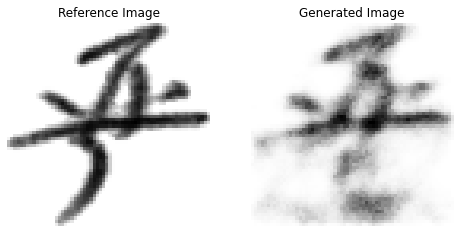

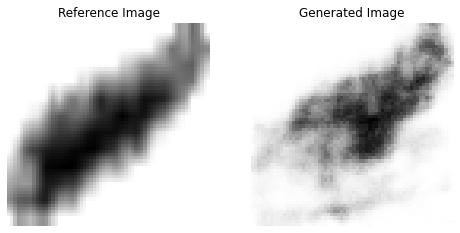

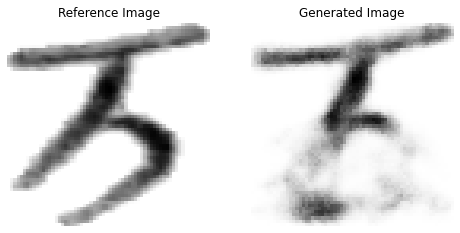

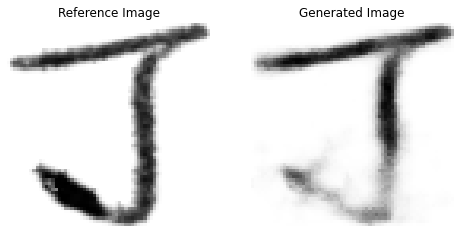

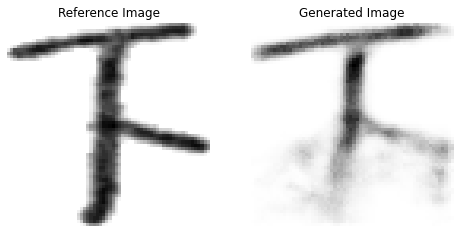

In [11]:
import matplotlib.pyplot as plt
import torch

def plot_generated_images(model, data_loader, num_images, batch_size, device='cpu'):
    model.eval()
    left_images = num_images
    with torch.no_grad():
        for batch_idx, (data, condition) in enumerate(data_loader):
            condition = condition.to(device)
            data = data.to(device)
            if left_images == 0:
                break
            
            z = torch.randn(batch_size, model.z_dim).to(device)
            sample = model.decode(z, condition).cpu()
            sample = sample.view(batch_size, 1, 64, 64)
            
            if left_images > batch_size:
                print_images = batch_size
                left_images = left_images-batch_size
            else:
                print_images = left_images
                left_images = 0
                

            for i in range(print_images):
                ref = data[i].cpu().detach().numpy().reshape(64, 64)
                img = sample[i].cpu().detach().numpy().reshape(64, 64)

                plt.figure(figsize=(8, 4))

                # Plot reference image
                plt.subplot(1, 2, 1)
                plt.title('Reference Image')
                plt.imshow(ref, cmap='gray')
                plt.axis('off')

                # Plot generated image
                plt.subplot(1, 2, 2)
                plt.title('Generated Image')
                plt.imshow(img, cmap='gray')
                plt.axis('off')

                plt.show()

# Example usage:
# Assuming `model` is an instance of CVAE and `train_loader` is your DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
plot_generated_images(model, train_loader, num_images=5, batch_size=32, device=device)